In [79]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import urllib.request
!pip install geocoder
import geocoder

## Identifying Toronto postal codes doing web scrapping from wikipedia tables

In [80]:
postal = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
tabla = pd.read_html(postal)
df = tabla[0]

First 5 rows of the data set

In [81]:
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Last 5 rows of the data set

In [82]:
df.tail()

,Postal Code,Borough,Neighbourhood
175,M5Z,Not assigned,Not assigned
176,M6Z,Not assigned,Not assigned
177,M7Z,Not assigned,Not assigned
178,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."
179,M9Z,Not assigned,Not assigned


Remove not assigned boroughs

In [83]:
df = df[df.Borough != 'Not assigned']

In [84]:
df = df.sort_values(by = ['Postal Code','Borough'])

In [85]:
df.reset_index(inplace=True)

In [86]:
df.drop('index', axis = 1, inplace = True)

Get a clean sample of the previous data set

In [87]:
df.head()

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Import latitude and longitude file from cocl.us for every postal code 

In [88]:
df_geo = pd.read_csv('https://cocl.us/Geospatial_data')

In [89]:
df_geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Merging our first dataframe with latitude and longitude data identifying the Postal Code

In [90]:
df2=pd.merge(df, df_geo, on='Postal Code')

In [91]:
df2.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


Get Toronto Neighborhoods demographics in Scarborough area. Scarborough seems to be the most extensive district in Toronto. Also, information about Scarborough's neighborhoods is fully available in Wikipedia.

In [92]:
table = BeautifulSoup(urllib.request.urlopen('https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods').read(),'html.parser').find_all('table')[5]
table_rows = table.find_all('tr')
l = []
for tr in table_rows:
    #print (tr)
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td if tr.text.strip()]
    if row:
        l.append(row)

Scarborough map

In [93]:
from geopy.geocoders import Nominatim
import folium

In [94]:
address = 'Scarborough, TO'

geolocator = Nominatim(user_agent="scb_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Scarborough are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Scarborough are 43.7729744, -79.2576479.


In [95]:
map_scarborough = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(df2['Latitude'], df2['Longitude'], df2['Borough'], df2['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=30,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_scarborough)  
    
map_scarborough

Scarborough's neighborhoods. In order to solve my problem, I will take into account 3 variables: Population, Income and 2nd language.

In [96]:
df1 = pd.DataFrame(l, columns=["Neighbourhood", "FM", "Census", "Population", "Land Area", "Density", "Population %", "Income", "Commuting", "Renters", "2nd Language", "2nd Language %"])

# clean up the data and dropping unwanted columns
df1 = df1[df1.Neighbourhood != 'Toronto CMA Average']
df1 = df1.drop('FM', 1)
df1 = df1.drop('Census', 1)
df1 = df1.drop('Renters', 1)
df1 = df1.drop('Land Area', 1)
df1 = df1.drop('Density', 1)
df1 = df1.drop('Population %', 1)
df1 = df1.drop('Commuting', 1)
df1 = df1.drop('2nd Language %', 1)


# change to the proper datatype
df1['Population'] = df1['Population'].str.replace(',','')
df1['Population'] = df1['Population'].apply(pd.to_numeric)
#print (df1.dtypes)

# display sample data
df1.head()

,Neighbourhood,Population,Income,2nd Language
1,Agincourt,44577,"25,750",Cantonese (19.3%)
2,Alexandra Park,4355,"19,687",Cantonese (17.9%)
3,Allenby,2513,"245,592",Russian (1.4%)
4,Amesbury,17318,"27,546",Spanish (6.1%)
5,Armour Heights,4384,"116,651",Russian (9.4%)


In [97]:
df1.shape

(151, 4)

Cleaning the data set to identify most frecuently used 2nd language and highest incomes 

In [98]:
df1['2nd Language'] = df1['2nd Language'].str.replace('\d+', '')
df1['2nd Language'] = df1['2nd Language'].str.replace('\W', '')
df1['Income'] = df1['Income'].str.replace('\W', '')

In [99]:
df1.head()

,Neighbourhood,Population,Income,2nd Language
1,Agincourt,44577,25750,Cantonese
2,Alexandra Park,4355,19687,Cantonese
3,Allenby,2513,245592,Russian
4,Amesbury,17318,27546,Spanish
5,Armour Heights,4384,116651,Russian


In [100]:
df1.shape

(151, 4)

In [101]:
df1['2nd Language'].unique()

array(['Cantonese', 'Russian', 'Spanish', 'UnspecifiedChinese',
       'Mandarin', 'Greek', 'Tamil', 'Ukrainian', 'Portuguese', 'Tagalog',
       'Korean', 'French', 'Filipino', 'Persian', 'Italian', 'Vietnamese',
       'Japanese', 'Urdu', 'Hindi', 'Polish', 'Punjabi', 'Serbian',
       'Bengali', 'None', 'Gujarati'], dtype=object)

In [102]:
lang_count = df1['2nd Language'].value_counts().to_frame()
lang_count.rename(columns={'2nd Language':'Count'})

,Count
Portuguese,21
UnspecifiedChinese,20
Cantonese,16
Tamil,12
Filipino,11
Spanish,10
Italian,10
Russian,8
French,6
Ukrainian,6


In [103]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

Text(0, 0.5, '# of neighbourhoods')

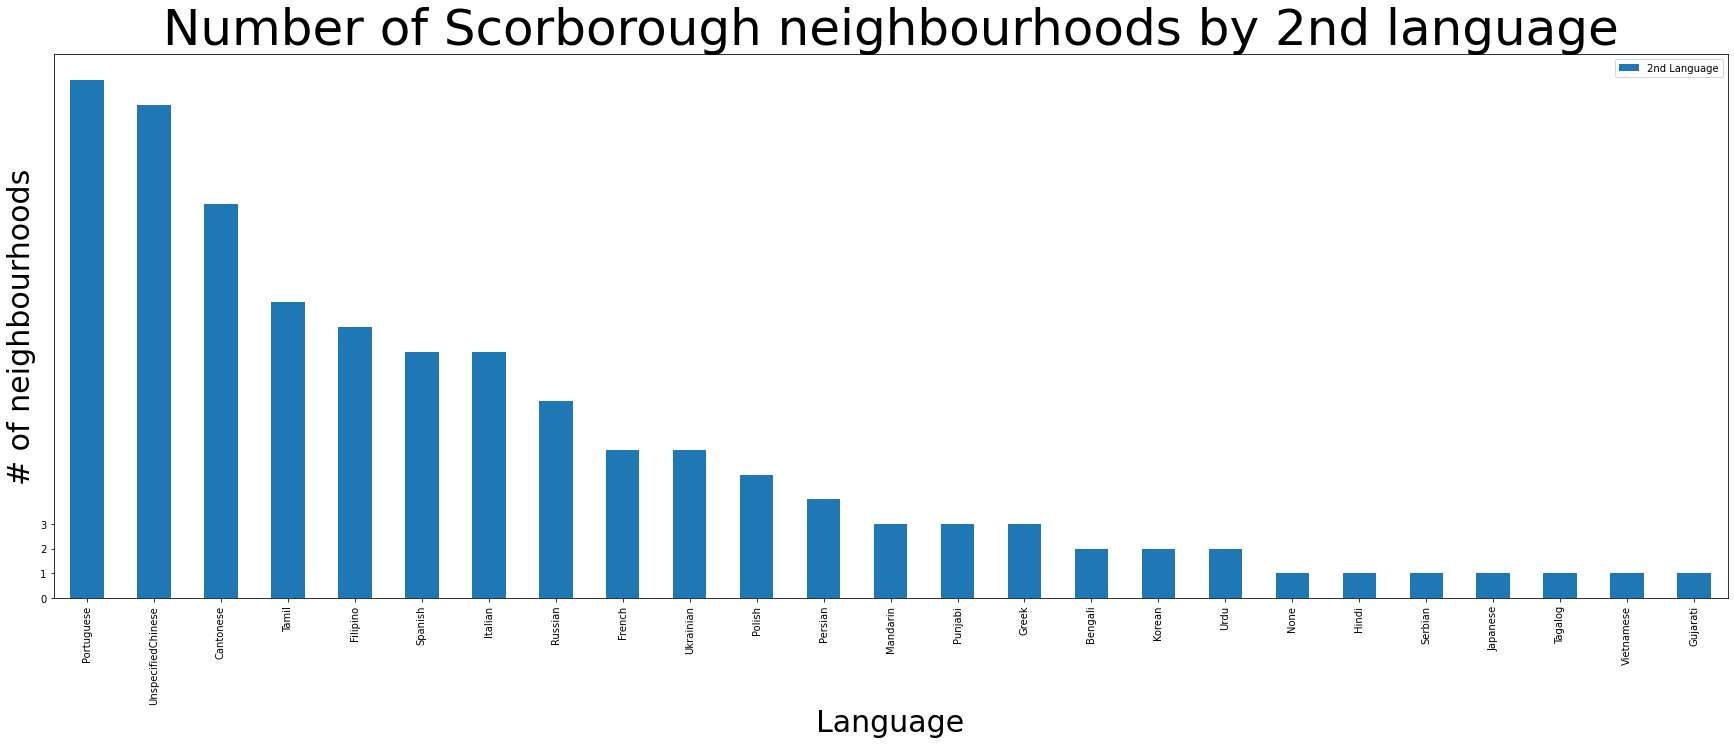

In [104]:
yint = range(0,4)
lang_count.plot(kind='bar', figsize=(30,10))
plt.yticks(yint)
plt.title('Number of Scorborough neighbourhoods by 2nd language',fontsize=50)
plt.xlabel('Language', fontsize=30)
plt.ylabel('# of neighbourhoods',fontsize=30)

Given that Portuguese (Portugal, Brazil, some african countries), Chinese (China, Taiwan, Singapur), Cantonese (China), Tamil (India, Sri Lanka, Singapur), Filipino (Filipinas), Italian (Italia) and Spanish (Spain, Latin America),  are the most frecuent 2nd Languages in Scarborough, in the next steps I'll focus on venues (restaurants) that could be familiar with those languages. 

In [105]:
df1.describe()

,Population
count,151.000000
mean,13814.198675
std,10336.645429
min,548.000000
25%,5881.500000
50%,11167.000000
75%,17800.500000
max,48507.000000


From the original dataset, I'll extract only Scarborough's information

In [106]:
df_scb = df2[df2['Borough'] == 'Scarborough'].reset_index(drop=True)
df_scb

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


The last 2 dataframes will be our data. I'll now explore venues in Scarborough's neighbourhoods.

##Foursquare API credentials

In [107]:
CLIENT_ID = 'YTWFPCXLMOCH1JJE2MCBMYE13IMCI0FUISLWQ0EURGQK2LHN' 
CLIENT_SECRET = 'CWTFL043FB2WCE2MBBMEUS2YQXTKGQSDVWTOVBBW1UTDKYKI'
VERSION = '20210701'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YTWFPCXLMOCH1JJE2MCBMYE13IMCI0FUISLWQ0EURGQK2LHN
CLIENT_SECRET:CWTFL043FB2WCE2MBBMEUS2YQXTKGQSDVWTOVBBW1UTDKYKI


In [108]:
import requests

In [109]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

List of Scarborough venues

In [110]:
scb_venues = getNearbyVenues(names=df_scb['Neighbourhood'],
                                   latitudes=df_scb['Latitude'],
                                   longitudes=df_scb['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge


In [111]:
scb_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Great Shine Window Cleaning,43.783145,-79.157431,Home Service
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,SEBS Engineering Inc. (Sustainable Energy and ...,43.782371,-79.156820,Construction & Landscaping
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank


In [112]:
scb_venues.shape

(89, 7)

In [113]:
scb_venues['Venue Category'].unique

<bound method Series.unique of 0           Fast Food Restaurant
1                   Home Service
2                            Bar
3     Construction & Landscaping
4                           Bank
                 ...            
84          Fast Food Restaurant
85                Breakfast Spot
86             Electronics Store
87                   Coffee Shop
88                  Burger Joint
Name: Venue Category, Length: 89, dtype: object>

In [114]:
scb_venues.rename(columns={'Venue Category':'Category'}, inplace=True)

In [115]:
scb_cat = scb_venues['Category'].value_counts().to_frame()
scb_cat.rename(columns={'Category':'Count'})

,Count
Coffee Shop,5
Bakery,4
Fast Food Restaurant,4
Bank,4
Intersection,4
Pizza Place,4
Breakfast Spot,3
Chinese Restaurant,3
Pharmacy,3
Fried Chicken Joint,2


From the Scarborough venues, I'm going to extract venues that are related to the above 2nd language list 

In [116]:
scb_venues_2nd = scb_venues.loc[(scb_venues.Category == 'Chinese Restaurant') | 
               (scb_venues.Category == 'Indian Restaurant') | 
               (scb_venues.Category == 'Hakka Restaurant') | 
               (scb_venues.Category == 'Mexican Restaurant') | 
               (scb_venues.Category == 'Latin American Restaurant') | 
               (scb_venues.Category == 'Italian Restaurant')]

In [117]:
scb_venues_2nd

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Category
7,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant
15,Cedarbrae,43.773136,-79.239476,Federick Restaurant,43.774697,-79.241142,Hakka Restaurant
47,"Dorset Park, Wexford Heights, Scarborough Town...",43.757410,-79.273304,Kim Kim restaurant,43.753833,-79.276611,Chinese Restaurant
48,"Dorset Park, Wexford Heights, Scarborough Town...",43.757410,-79.273304,Karaikudi Chettinad South Indian Restaurant,43.756042,-79.276276,Indian Restaurant
49,"Dorset Park, Wexford Heights, Scarborough Town...",43.757410,-79.273304,Kairali,43.754915,-79.276945,Indian Restaurant
58,Agincourt,43.794200,-79.262029,El Pulgarcito,43.792648,-79.259208,Latin American Restaurant
61,"Clarks Corners, Tam O'Shanter, Sullivan",43.781638,-79.304302,Remezzo Italian Bistro,43.778649,-79.308264,Italian Restaurant
62,"Clarks Corners, Tam O'Shanter, Sullivan",43.781638,-79.304302,The Royal Chinese Restaurant 避風塘小炒,43.780505,-79.298844,Chinese Restaurant
76,"Steeles West, L'Amoreaux West",43.799525,-79.318389,Mr Congee Chinese Cuisine 龍粥記,43.798879,-79.318335,Chinese Restaurant


In [118]:
scb_onehot = pd.get_dummies(df1[['2nd Language']], prefix="", prefix_sep="")
scb_onehot['Neighbourhood'] = df1['Neighbourhood'] 
fixed_columns = [scb_onehot.columns[-1]] + list(scb_onehot.columns[:-1])
scb_onehot = scb_onehot[fixed_columns]
scb_onehot.head()

,Neighbourhood,Bengali,Cantonese,Filipino,French,Greek,Gujarati,Hindi,Italian,Japanese,Korean,Mandarin,None,Persian,Polish,Portuguese,Punjabi,Russian,Serbian,Spanish,Tagalog,Tamil,Ukrainian,UnspecifiedChinese,Urdu,Vietnamese
1,Agincourt,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Alexandra Park,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Allenby,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,Amesbury,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,Armour Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [119]:
scb_grouped = scb_onehot.groupby('Neighbourhood').mean().reset_index()
scb_grouped

,Neighbourhood,Bengali,Cantonese,Filipino,French,Greek,Gujarati,Hindi,Italian,Japanese,Korean,Mandarin,None,Persian,Polish,Portuguese,Punjabi,Russian,Serbian,Spanish,Tagalog,Tamil,Ukrainian,UnspecifiedChinese,Urdu,Vietnamese
0,Agincourt,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Alexandra Park,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Allenby,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,Amesbury,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,Armour Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,Woburn,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
147,Wychwood,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
148,York Mills,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
149,York University Heights,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Clustering neighbourhoods in Scarborough

In [120]:
from sklearn.cluster import KMeans

In [121]:
# set number of clusters
kclusters = 5

dfkm = scb_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dfkm)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 4, 0, 0, 0, 1, 0, 0, 4, 4], dtype=int32)

In [122]:
# add clustering labels
df1.insert(0, 'Cluster Labels', kmeans.labels_)

df1

,Cluster Labels,Neighbourhood,Population,Income,2nd Language
1,4,Agincourt,44577,25750,Cantonese
2,4,Alexandra Park,4355,19687,Cantonese
3,0,Allenby,2513,245592,Russian
4,0,Amesbury,17318,27546,Spanish
5,0,Armour Heights,4384,116651,Russian
...,...,...,...,...,...
147,0,Woburn,48507,26190,Gujarati
148,3,Wychwood,4182,53613,Portuguese
149,0,York Mills,17564,92099,Korean
150,0,York University Heights,26140,24432,Italian


In [123]:
df1.sort_values(by=['Cluster Labels'])

,Cluster Labels,Neighbourhood,Population,Income,2nd Language
76,0,Lawrence Park,6653,214110,French
101,0,Port Union,12450,48117,Filipino
100,0,Port Lands,571,36243,Mandarin
97,0,Pelmo Park,4402,32002,Italian
94,0,Parkdale,28367,26314,Polish
...,...,...,...,...,...
78,4,Leslieville,23567,30886,Cantonese
43,4,East Danforth,21440,33847,Cantonese
70,4,Kensington Market,3740,23335,Cantonese
9,4,Bayview Village,12280,46752,Cantonese


##A view of each Cluster

In [124]:
df1.rename(columns={'Cluster Labels':'Cluster'}, inplace=True)
df10 = df1.loc[(df1.Cluster == 0)]
df10

,Cluster,Neighbourhood,Population,Income,2nd Language
3,0,Allenby,2513,245592,Russian
4,0,Amesbury,17318,27546,Spanish
5,0,Armour Heights,4384,116651,Russian
7,0,Bathurst Manor,14945,34169,Russian
8,0,Bay Street Corridor,4787,40598,Mandarin
...,...,...,...,...,...
146,0,Wilson Heights,13732,37978,Filipino
147,0,Woburn,48507,26190,Gujarati
149,0,York Mills,17564,92099,Korean
150,0,York University Heights,26140,24432,Italian


In [125]:
df11 = df1.loc[(df1.Cluster == 1)]
df11

,Cluster,Neighbourhood,Population,Income,2nd Language
6,1,Banbury,6641,92319,UnspecifiedChinese
13,1,Birch Cliff,12266,48965,UnspecifiedChinese
19,1,Cabbagetown,11120,50398,UnspecifiedChinese
34,1,Discovery District,7262,41998,UnspecifiedChinese
36,1,Don Mills,21372,47515,UnspecifiedChinese
37,1,Don Valley Village,29740,30442,UnspecifiedChinese
51,1,Garden District,8240,37614,UnspecifiedChinese
53,1,Grange Park,9007,35277,UnspecifiedChinese
57,1,Harbourfront / CityPlace,14368,69232,UnspecifiedChinese
62,1,Hillcrest,18327,33465,UnspecifiedChinese


In [126]:
df12 = df1.loc[(df1.Cluster == 2)]
df12

,Cluster,Neighbourhood,Population,Income,2nd Language
12,2,Bendale,28945,29723,Tamil
27,2,Cliffcrest,14531,38182,Tamil
38,2,Dorset Park,14189,26525,Tamil
44,2,Eglinton East,22387,25307,Tamil
61,2,Highland Creek,12853,33640,Tamil
82,2,Malvern,44324,25677,Tamil
87,2,Morningside,11472,27139,Tamil
109,2,Rouge,22724,29230,Tamil
112,2,Scarborough Junction,25780,25405,Tamil
113,2,Scarborough City Centre,16403,26756,Tamil


In [127]:
df13 = df1.loc[(df1.Cluster == 3)]
df13

,Cluster,Neighbourhood,Population,Income,2nd Language
18,3,Brockton,9039,27260,Portuguese
21,3,Carleton Village,6544,23301,Portuguese
24,3,Christie Pits,5124,30556,Portuguese
31,3,Davenport,8781,28335,Portuguese
39,3,Dovercourt Park,8497,28311,Portuguese
41,3,Dufferin Grove,9875,27961,Portuguese
42,3,Earlscourt,17240,26672,Portuguese
46,3,Fashion District,4642,63282,Portuguese
56,3,Harbord Village,5906,45792,Portuguese
58,3,Harwood,3375,22136,Portuguese


In [128]:
df14 = df1.loc[(df1.Cluster == 4)]
df14

,Cluster,Neighbourhood,Population,Income,2nd Language
1,4,Agincourt,44577,25750,Cantonese
2,4,Alexandra Park,4355,19687,Cantonese
9,4,Bayview Village,12280,46752,Cantonese
10,4,Bayview Woods – Steeles,13298,41485,Cantonese
17,4,Bridle Path,1540,314107,Cantonese
28,4,Cliffside,9386,32701,Cantonese
43,4,East Danforth,21440,33847,Cantonese
70,4,Kensington Market,3740,23335,Cantonese
78,4,Leslieville,23567,30886,Cantonese
85,4,Milliken,26272,25243,Cantonese


In [129]:
df10=df10.astype({"Cluster": int, "Neighbourhood": str, "Population":int, "Income":float, "2nd Language":str})
df11=df11.astype({"Cluster": int, "Neighbourhood": str, "Population":int, "Income":float, "2nd Language":str})
df12=df12.astype({"Cluster": int, "Neighbourhood": str, "Population":int, "Income":float, "2nd Language":str})
df13=df13.astype({"Cluster": int, "Neighbourhood": str, "Population":int, "Income":float, "2nd Language":str})
df14=df14.astype({"Cluster": int, "Neighbourhood": str, "Population":int, "Income":float, "2nd Language":str})


Mean income per Cluster

In [130]:
mincome=[df10["Income"].mean(), df11["Income"].mean(), df12["Income"].mean(),df13["Income"].mean(),df14["Income"].mean()]

In [131]:
mincome

[53836.65853658537, 61929.05, 28327.75, 33122.142857142855, 53560.875]

Conclusión nueva